# An analysis of Purchasing power development of households in the Netherlands between 2012-2022
***

Author: Tristan, Alex, Shant, Sam

## Introduction
This analysis will show some insights regarding the development of purchasing power of families in the Netherlands using CBS data. This is done to answer the following questions:

1. What, if any, is the change in purchasing power for families of different types (Single person household, One-parent family, Couple, no children, and Couple, with child(ren))?
2. Does the median development of purchasing power for all persons correlate with the change in inflation over the same period?

The data can be found [here](https://www.cbs.nl/en-gb/figures/detail/83781ENG#shortTableDescription)

## Explanation of symbols

| Symbol | Explanation |
| --- | --- | 
| . | figure is unknown, insufficiently reliable or confidential |
|*|provisional figure|
|**|revised provisional figure|
|–|(between two numbers) inclusive|
|0 (0.0)|less than half of unit concerned|
|2016–2017|average for the years 2016 up to and including 2017|
|2016/’17|crop year, financial year, school year etc., beginning in 2016 and ending in 2017|
|2004/’05–2016/’17|crop year etc. 2004/’05 up to and including 2016/’17|

## Notebook configuration


In [139]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

##Data exploration

During this part we will explore the data and decide what to do with data that falls outside expectations. 

In [140]:
#load the addtional information
df_extra = pd.read_csv("C:\\Users\\Silen\\Downloads\\HouseholdCharacteristics.csv", sep=",")

#load the main dataset
df = pd.read_csv("C:\\Users\\Silen\\Downloads\\UntypedDataSet.csv", sep=",")

#merge the dataset so what we have the correct descriptions and titles
df=pd.merge(df,df_extra, left_on='HouseholdCharacteristics',right_on='Key' ,how='left')

#remove the duplicate column that was used to join
del df['Key']

#create a proper year integer in the periods column
df['Periods'] = df['Periods'].str[:4].astype(int)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    528 non-null    int64  
 1   HouseholdCharacteristics              528 non-null    object 
 2   Periods                               528 non-null    int32  
 3   MedianDevelopmentPurchasingPower_1    528 non-null    float64
 4   PersonsWithPurchasingPowerDecrease_2  528 non-null    float64
 5   PersonsWithPurchasingPowerIncrease_3  528 non-null    float64
 6   k_20thPercentile_4                    528 non-null    float64
 7   k_40thPercentile_5                    528 non-null    float64
 8   k_60thPercentile_6                    528 non-null    float64
 9   k_80thPercentile_7                    528 non-null    float64
 10  Title                                 528 non-null    object 
 11  Description        

This information shows that there are a few rows where there are null values present. Further investigation is required to if this is a problem.                     

In [141]:
#print rows that have an empty description
print(df[df['Description'].isna()])

    ID HouseholdCharacteristics  Periods  MedianDevelopmentPurchasingPower_1  \
0    0                  T009002     2012                                -1.1   
1    1                  T009002     2013                                -1.1   
2    2                  T009002     2014                                 1.9   
3    3                  T009002     2015                                 1.3   
4    4                  T009002     2016                                 3.0   
5    5                  T009002     2017                                 0.7   
6    6                  T009002     2018                                 0.6   
7    7                  T009002     2019                                 1.5   
8    8                  T009002     2020                                 2.5   
9    9                  T009002     2021                                 1.4   
10  10                  T009002     2022                                -1.2   

    PersonsWithPurchasingPowerDecrease_

Using this information we can infer that this is not a problem as the description is used to provide subcategories to the title column. However as this data pertains to the total persons, no smaller groups can be made. 

Now we can continue with some logical checks to further assess data quality. Important to note is that we can only check the technical quality of the data as we do not have acces to the raw data that was used to produce these totals. For this descriptive analysis we thus assume that CBS has not made any errors on that end. 

In [142]:
#check the first few rows
print(df.head())

   ID HouseholdCharacteristics  Periods  MedianDevelopmentPurchasingPower_1  \
0   0                  T009002     2012                                -1.1   
1   1                  T009002     2013                                -1.1   
2   2                  T009002     2014                                 1.9   
3   3                  T009002     2015                                 1.3   
4   4                  T009002     2016                                 3.0   

   PersonsWithPurchasingPowerDecrease_2  PersonsWithPurchasingPowerIncrease_3  \
0                                  57.8                                  42.2   
1                                  56.0                                  44.0   
2                                  37.6                                  62.4   
3                                  40.4                                  59.6   
4                                  32.3                                  67.7   

   k_20thPercentile_4  k_40thPercentil

Here we can hypothesize the following constraints: 

    1. The columns that we expect to hold numeric values do so and they are not empty. 
    2. Purchasingpower increase and decrease should add up to 100 and neither should be >= 100.
    3. While there is no max or min for the median development or the percentiles we should explore any outliers.
    
As 1 has been confirmed previously, we will test 2 and 3. 

In [143]:
#add the totals of the columns purchasing power increase and decrease together and check if this equals 100. Then check if the amount of times this holds true equals the amount of rows. 

#create new dataframe with the 2 columns of interest and add a total
df_purch_qcheck = df[['PersonsWithPurchasingPowerDecrease_2','PersonsWithPurchasingPowerIncrease_3']]

df_purch_qcheck['sum_purch_dec_inc'] = df_purch_qcheck.loc[:,'PersonsWithPurchasingPowerDecrease_2'] + df_purch_qcheck.loc[:,'PersonsWithPurchasingPowerIncrease_3']

rows_df = len(df)

sum_where_100 = sum(df_purch_qcheck['sum_purch_dec_inc'] == 100)

#print comparison
if sum_where_100 == rows_df:
    print(f"The amount of rows in the dataframe ({rows_df}) matches the amount of times the amount of times ({sum_where_100}) the two columns adds up to 100.0 \n")
else:
    print(f"There is a mismatch between the amount of rows {rows_df} and the amount of rows ({sum_where_100}) that have a sum of 100.0.\n") 


#check minimum and maximum of the columns
person_purch_pow_dec_min = min(df['PersonsWithPurchasingPowerDecrease_2'])
person_purch_pow_dec_max = max(df['PersonsWithPurchasingPowerDecrease_2'])
person_purch_pow_inc_min = min(df['PersonsWithPurchasingPowerIncrease_3'])
person_purch_pow_inc_max = max(df['PersonsWithPurchasingPowerIncrease_3'])

print(f"The minimum of PersonsWithPurchasingPowerDecrease_2 is {person_purch_pow_dec_min} and the maximum is {person_purch_pow_dec_max}.\n")
print(f"The minimum of PersonsWithPurchasingPowerIncrease_3 is {person_purch_pow_inc_min} and the maximum is {person_purch_pow_inc_max}.\n")

The amount of rows in the dataframe (528) matches the amount of times the amount of times (528) the two columns adds up to 100.0 

The minimum of PersonsWithPurchasingPowerDecrease_2 is 21.3 and the maximum is 82.0.

The minimum of PersonsWithPurchasingPowerIncrease_3 is 18.0 and the maximum is 78.7.



We can conclude that this matches our expectations. Now can investigate the minima and maxima of the purchasing power development percentiles. 

In [144]:

print(f"The max of k_20thPercentile_4 is {max(df['k_20thPercentile_4'])} and its minimum is {min(df['k_20thPercentile_4'])}. \n")
print(f"The max of k_40thPercentile_5 is {max(df['k_40thPercentile_5'])} and its minimum is {min(df['k_40thPercentile_5'])}. \n")
print(f"The max of k_60thPercentile_6 is {max(df['k_60thPercentile_6'])} and its minimum is {min(df['k_60thPercentile_6'])}. \n")
print(f"The max of k_80thPercentile_7 is {max(df['k_80thPercentile_7'])} and its minimum is {min(df['k_80thPercentile_7'])}. \n")


The max of k_20thPercentile_4 is -0.5 and its minimum is -36.3. 

The max of k_40thPercentile_5 is 4.5 and its minimum is -14.1. 

The max of k_60thPercentile_6 is 18.6 and its minimum is -2.6. 

The max of k_80thPercentile_7 is 56.0 and its minimum is -0.2. 



Looking at this information we see nothing too strange. Based on this we can see that the largest increase for the majority (80th percentile) has been below or equal to a purchasing power increase of 56 percent while the lowest is a decrease of 0.2 percent. But in order to understand how often this happens we can visualize the data. 

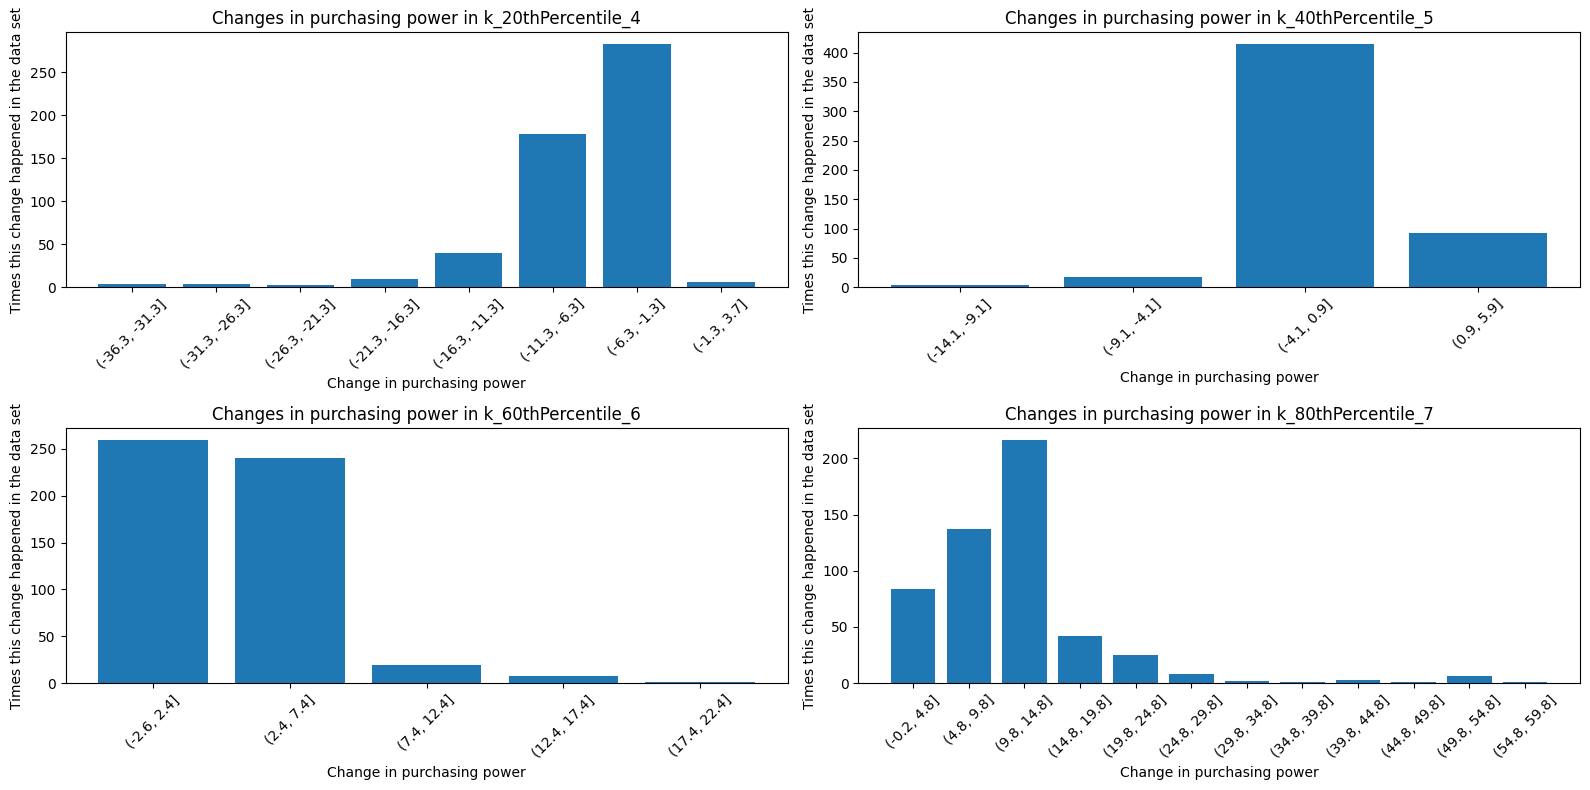

In [145]:
#create an occcurence list 
values_20_perc = df['k_20thPercentile_4'].value_counts()
values_20_perc = df['k_20thPercentile_4'].value_counts()
values_20_perc = df['k_20thPercentile_4'].value_counts()
values_20_perc = df['k_20thPercentile_4'].value_counts()

df_2= df[["k_20thPercentile_4","k_40thPercentile_5","k_60thPercentile_6","k_80thPercentile_7"]]

#setup figure and axes for a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

#this makes it easier for the for loop to iterate over the columns
axes = axes.flatten()

#set bin size 
bin_size = 5

#create a for loop that creates a bar chart with bins of 5 for each of the percentiles in the data set
for i, col in enumerate(df_2.columns):
    #create bins and bin data and ensure that the maxima and minima are available in the charts
    bins = np.arange(df_2[col].min(), df_2[col].max() + bin_size, bin_size)
    binned_data = pd.cut(df_2[col], bins=bins)
    bin_counts = binned_data.value_counts().sort_index()
    
    #set names of the axis
    axes[i].bar(bin_counts.index.astype(str), bin_counts.values)
    axes[i].set_title(f'Changes in purchasing power in {col}')
    axes[i].set_xlabel('Change in purchasing power')
    axes[i].set_ylabel('Times this change happened in the data set')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

With this visualization we have further corroborated the hypothesis that the maximum change in purchasing power seen in the 80th percentile bracket is a rare occurence. This is likely due to a specific definition of the group but for now this does not warrant further research.

## Exploring potential changes in purchasing power for families of different types
In the dataset we can see the following labels for the groups that interest us:
    1. 1050015 - Type: Single person household
    2. 1050190 - Type: One-parent family
    3. 1017780 - Type: Couple, no children
    4. 1016090 - Type: Couple, with child(ren)

We need to isolate these groups and check if we can see the difference in purchasing power change per group. 

In [146]:
df_interest = df[df["HouseholdCharacteristics"].isin(['1050015','1050190','1017780','1016090'])]

#create an overview of the maxima, minima, and mean of MedianDevelopmentPurchasingPower_1 for each group. 
df_interest2 = pd.pivot_table(df_interest, values='MedianDevelopmentPurchasingPower_1', index='Title', aggfunc= {'MedianDevelopmentPurchasingPower_1': ["min", "max", "mean"]},fill_value=None)

print(df_interest2)

                               max      mean  min
Title                                            
Type: Couple, no children      1.4 -0.136364 -2.9
Type: Couple, with child(ren)  5.3  2.463636 -0.5
Type: One-parent family        3.6  1.563636 -1.3
Type: Single person household  1.7  0.290909 -1.5


Using this information we can conclude that the biggest positive change on average was for the group Couple, with child(ren) while the Couple, no children was the only group that saw a decrease in purchasing power on average over time. Using this information let's see if we can visualize this change over time for the aforementioned groups. 

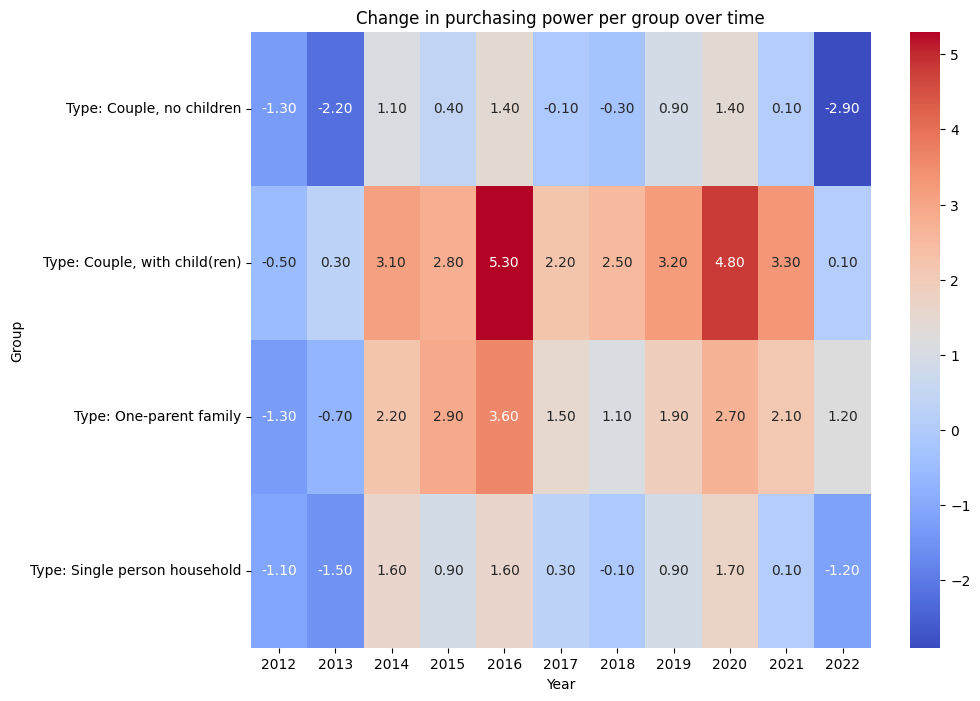

In [147]:
pivot_df = df_interest.pivot(index='Title', columns='Periods', values='MedianDevelopmentPurchasingPower_1')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Change in purchasing power per group over time')
plt.xlabel('Year')
plt.ylabel('Group')
plt.show()

With this we can see that while a couple with children saw the largest average increase in purchasing power(pp) over the recorded time, last year the group One-parent family had a larger increase in pp. We can also see that a couple without children only saw an increase in pp 6 out of the 11 years. A single person household followed closely with 7/11 years having a positive change in pp. Further analysis is needed to see if this can be correlated with the (delayed) effects of laws or regulations but this falls outside the scope of this analysis. 

In [148]:
#filter the original dataset on the group we find interesting
df_total_persons = df[df['HouseholdCharacteristics'] == 'T009002']
 
#load the inflation dataset 
df_inflation = pd.read_csv("C:\\Users\\Silen\\Downloads\\inflation_netherlands.csv", sep=";")

#check if there are na values
print(df_inflation.info())

#compare the periods with Jaar to see if all the values from df 1 can be found in df 2
df_year_compare= set(df_total_persons['Periods']) - set(df_inflation['Jaar'].unique())

if len(df_year_compare) == 0:
    print("All years from df_total_persons can be found in df_inflation")
else:
    print(f"The following years from df_total_persons were not found in df_inflation : {df_year_compare}")

#set the datatype of the cyclus to a float and convert commas in the numbers to points
df_inflation['Cyclus'] = df_inflation['Cyclus'].str.replace(',', '.', regex=False).astype(float)

 
#aggregate the inflation data on a yearly level and calculate the mean per year
df_inflation = df_inflation.groupby('Jaar')['Cyclus'].mean().reset_index()

#filter df_inflation on the years in df_total_persons and join the tables together
df_inflation = df_inflation[df_inflation['Jaar'].isin(df_total_persons['Periods'])]

df_total_persons_corr = pd.merge(df_total_persons,df_inflation, left_on='Periods', right_on='Jaar', how='inner')

del df_total_persons_corr['Jaar']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Jaar    278 non-null    int64 
 1   Maand   278 non-null    object
 2   Cyclus  278 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.6+ KB
None
All years from df_total_persons can be found in df_inflation


Now that the dataset is prepared we can do a simplified version of a check to see whether we should use. First lets have a look at the data

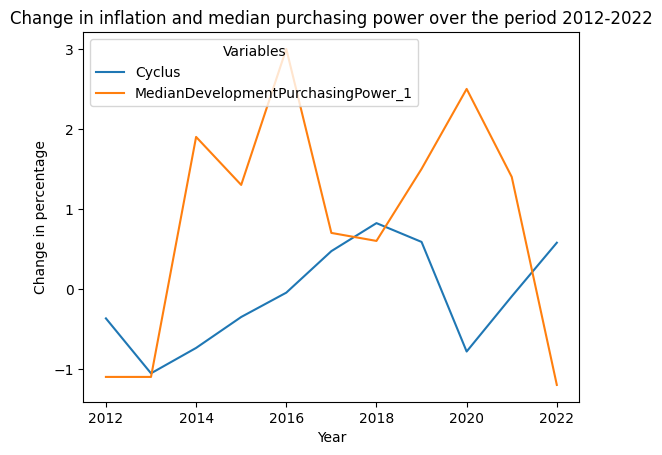

In [149]:
#create a line chart of the inflation and change in purchasing power

df_melted = df_total_persons_corr.melt(id_vars=['Periods'], value_vars=['Cyclus', 'MedianDevelopmentPurchasingPower_1'], var_name='Variables', value_name='Value')
sns.lineplot(data=df_melted, x='Periods', y='Value', hue='Variables')
plt.title("Change in inflation and median purchasing power over the period 2012-2022")
plt.xlabel("Year")
plt.ylabel("Change in percentage")
plt.show()



 We can see that the lines are somwhat following the same pattern but we need to use a scatterplot to see if we can see more about the distribution.

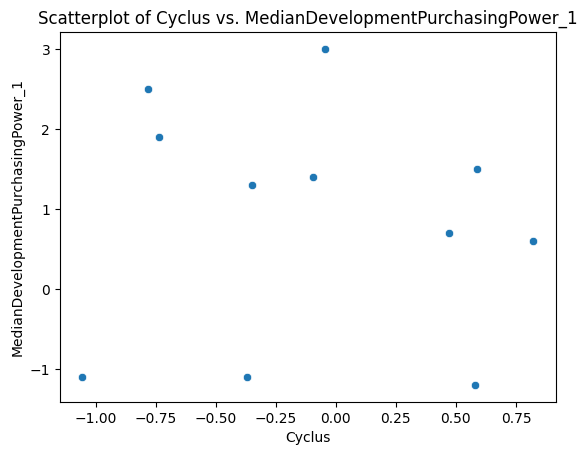

In [150]:
#create a scatterplot of the two values
sns.scatterplot(x='Cyclus', y='MedianDevelopmentPurchasingPower_1', data=df_total_persons_corr)
plt.title('Scatterplot of Cyclus vs. MedianDevelopmentPurchasingPower_1')
plt.show()

As we see a non-linear distribution, we will use Spearman to test correlation. We could do a normality test with code but in order to keep it simple, we shall proceed without extensively testing all other the required hypotheses. Normally, we should do that as weve learned. 

In [151]:
#use a pearson test to test for correlation
spearman_corr, spearman_pvalue = stats.pearsonr(df_total_persons_corr['Cyclus'], df_total_persons_corr['MedianDevelopmentPurchasingPower_1'])

print(f"Spearman's Correlation Coefficient: {spearman_corr}")
print(f"P-value: {spearman_pvalue}")

Spearman's Correlation Coefficient: -0.07179890710196137
P-value: 0.8338385875694807


Based on the results gathered by the Spearman's test for correlation we can conclude that based on this small dataset there is a very weak negative linear relationship. Due to the P value being much higher than the standard alpha of 0.05 we will not reject the null hypothesis and conclude that here is no correlation between inflation and purchasing power for the total people as defined in this data set. But, a lot more research is needed as this data analysis is done on data which has gone through several rounds of aggration and combining which means that there is a change there is a correlation between the underlying data points. 